<a href="https://colab.research.google.com/github/kaicong12/CRNN-HandWriting-Recognition/blob/main/BaseLine_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!mkdir -p words xml HTR_Using_CRNN/Model

In [3]:
!tar -xzf  "/content/gdrive/MyDrive/Colab Notebooks/words.tgz" -C "/content/words/"
!tar -xzf  "/content/gdrive/MyDrive/Colab Notebooks/xml.tgz" -C "/content/xml/"
!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/Real_HandWriting.zip" -d "/content/Real_HandWriting"

replace /content/Real_HandWriting/__MACOSX/._Real_HandWriting? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Data Preprocessing

In [5]:
import numpy as np
import cv2
import os
import os.path as osp
import pandas as pd
import glob
import string
import matplotlib.pyplot as plt
from datetime import datetime
import xml.etree.cElementTree as et

from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [7]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4083228234435945012
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8465726319705283339
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [8]:
# This step is to check GPU is available or not.

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [10]:
# dataset related variables
SAMPLE_SIZE = 50000
MAX_LABEL_LEN = 0
CHAR_LIST = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []


# model related variables
BATCH_SIZE = 8
EPOCHS = 30
E = str(EPOCHS)
OPTIMIZER_NAME = 'sgd'

In [11]:
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(CHAR_LIST.index(chara))
        
    return dig_lst

In [12]:
def extract_words_from_directories(xml_dir, png_dir):
    words = []
    xml_files = os.listdir(xml_dir)

    for xml_filename in xml_files:
      tree=et.parse(osp.join(xml_dir, xml_filename))
      root=tree.getroot()

      for word in root.iter('word'):
        text_id = word.attrib['id']

        splits = text_id.split("-")
        split_0 = splits[0]
        split_1 = "-".join(splits[:2])
        split_2 = "-".join(splits[2:])

        filepath = osp.join(png_dir, split_0, split_1, f"{text_id}.png")

        # filepath = f"/content/words/{split_0}/{split_1}/{text_id}.png"
        if not osp.isfile(filepath):
          raise Exception(f"{filepath} not found.")

        words.append({
            'id': text_id,
            'image_filepath': filepath,
            'text': word.attrib['text']
        })
    
    return words


In [13]:
def process_image(img):
      """
      Converts image to shape (32, 128, 1) & normalize
      """
      w, h = img.shape
      
      # image thresholding
  #     _, img = cv2.threshold(img, 
  #                            128, 
  #                            255, 
  #                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
      
      # Aspect Ratio Calculation
      new_w = 32
      new_h = int(h * (new_w / w))
      img = cv2.resize(img, (new_h, new_w))
      w, h = img.shape
      
      img = img.astype('float32')
      
      # Converts each to (32, 128, 1)
      if w < 32:
          add_zeros = np.full((32-w, h), 255)
          img = np.concatenate((img, add_zeros))
          w, h = img.shape

      if h < 128:
          add_zeros = np.full((w, 128-h), 255)
          img = np.concatenate((img, add_zeros), axis=1)
          w, h = img.shape
          
      if h > 128 or w > 32:
          dim = (128,32)
          img = cv2.resize(img, dim)
      
      # subtract is to make white pixels black and black pixels white
      img = cv2.subtract(255, img)

      img = np.expand_dims(img, axis=2)

      # Normalize
      cv2.normalize(img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

      return img

In [14]:
# read in words and annotations from directory
data = extract_words_from_directories("/content/xml", "/content/words")

In [15]:
data[0]

{'id': 'r06-041-00-00',
 'image_filepath': '/content/words/r06/r06-041/r06-041-00-00.png',
 'text': 'There'}

In [16]:
for index, word in enumerate(data):
    image_filepath = word['image_filepath']
    text = word['text']

    # processing on image
    img = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)

    try:
        img = process_image(img)
    except:
        continue

    # processing on label
    try:
        label = encode_to_labels(text)
    except:
        continue
    
    # added this line to prevent error from CTC computation
    if len(label) > 31:
      continue
    
    if index % 10 == 0:
        valid_images.append(img)
        valid_labels.append(label)
        valid_input_length.append(31)
        valid_label_length.append(len(text))
        valid_original_text.append(text)
    else:
        train_images.append(img)
        train_labels.append(label)
        train_input_length.append(31)
        train_label_length.append(len(text))
        train_original_text.append(text)
    
    if len(text) > MAX_LABEL_LEN:
        MAX_LABEL_LEN = len(text)
    
    if index > SAMPLE_SIZE:
        break

In [17]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=MAX_LABEL_LEN, 
                             padding='post',
                             value=len(CHAR_LIST))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=MAX_LABEL_LEN, 
                             padding='post',
                             value=len(CHAR_LIST))

In [18]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [19]:
train_images.shape, valid_images.shape

((44990, 32, 128, 1), (5001, 32, 128, 1))

# Model building

In [20]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(CHAR_LIST)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [21]:
the_labels = Input(name='the_labels', shape=[MAX_LABEL_LEN], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [22]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = OPTIMIZER_NAME, metrics=['accuracy'])

now = datetime.now()
date_time = now.strftime("%m_%d_%Y_%H%M%S")
filepath=f"HTR_Using_CRNN/Model/{date_time}.hdf5"

# Callback to monitor val loss
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
earlystopping = EarlyStopping(patience=5, monitor='val_loss', min_delta=0, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

callbacks_list = [earlystopping, lr_scheduler, checkpoint]

In [23]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30

Epoch 1: val_loss improved from inf to 4.93051, saving model to HTR_Using_CRNN/Model/11_08_2022_131602.hdf5
5624/5624 - 172s - loss: 8.7293 - accuracy: 0.1118 - val_loss: 4.9305 - val_accuracy: 0.2214 - 172s/epoch - 31ms/step
Epoch 2/30

Epoch 2: val_loss improved from 4.93051 to 3.04762, saving model to HTR_Using_CRNN/Model/11_08_2022_131602.hdf5
5624/5624 - 152s - loss: 3.6967 - accuracy: 0.3139 - val_loss: 3.0476 - val_accuracy: 0.4193 - 152s/epoch - 27ms/step
Epoch 3/30

Epoch 3: val_loss improved from 3.04762 to 2.76295, saving model to HTR_Using_CRNN/Model/11_08_2022_131602.hdf5
5624/5624 - 151s - loss: 2.6916 - accuracy: 0.4170 - val_loss: 2.7630 - val_accuracy: 0.4545 - 151s/epoch - 27ms/step
Epoch 4/30

Epoch 4: val_loss improved from 2.76295 to 2.40317, saving model to HTR_Using_CRNN/Model/11_08_2022_131602.hdf5
5624/5624 - 151s - loss: 2.1532 - accuracy: 0.4954 - val_loss: 2.4032 - val_accuracy: 0.5285 - 151s/epoch - 27ms/step
Epoch 5/30

Epoch 5: val_loss did no

KeyboardInterrupt: ignored

# Generate Test Set for Writer 10011

In [24]:
import glob

test_images = []
test_labels = []
test_input_length = []
test_label_length = []
test_original_text = []

def extract_real_handwriting(label_dir):
    words = []
    label_files = glob.glob(f"{label_dir}/*.txt")

    for label_filepath in label_files:
      text_id = osp.splitext(osp.basename(label_filepath))[0]
      
      # read in the txt file
      label = None
      with open(label_filepath, encoding="utf-8") as f:
        label = f.read().strip()
      
      # check if label is read in correctly
      assert label is not None, "Unable to detect label"
      
      image_filepath = osp.join(label_dir, f"{text_id}.png")
      if not osp.isfile(image_filepath):
          raise Exception(f"{image_filepath} not found.")

      words.append({
          'id': text_id,
          'image_filepath': image_filepath,
          'text': label
      })
    
    return words

In [25]:
test_data = extract_real_handwriting("/content/Real_HandWriting/Real_HandWriting")

In [26]:
for index, word in enumerate(test_data):
    image_filepath = word['image_filepath']
    text = word['text']

    # processing on image
    img = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)

    try:
        img = process_image(img)
    except:
        raise Exception("Unable to process image")

    # processing on label
    try:
        label = encode_to_labels(text)
    except Exception as e:
        raise Exception("Unable to process label")
    
    # added this line to prevent error from CTC computation
    if len(label) > 31:
      continue
    
    test_images.append(img)
    test_labels.append(label)
    test_input_length.append(31)
    test_label_length.append(len(text))
    test_original_text.append(text)

In [27]:
test_padded_label = pad_sequences(test_labels, 
                             maxlen=MAX_LABEL_LEN, 
                             padding='post',
                             value=len(CHAR_LIST))

test_images = np.asarray(test_images)
test_input_length = np.asarray(test_input_length)
test_label_length = np.asarray(test_label_length)

In [28]:
test_images.shape

(282, 32, 128, 1)

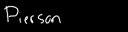

In [29]:
from google.colab.patches import cv2_imshow

cv2_imshow(test_images[0])

# Benchmark - Character Error Rate

In [30]:
def levenshtein_distance(s, t):
    dp = [[0 for i in range(len(t)+1)] for j in range(len(s)+1)]
    
    # fill in the border, can only be insert
    for i in range(1, len(dp)):
        dp[i][0] = i
    for j in range(1, len(dp[0])):
        dp[0][j] = j
    
    # s is vertical, t is horizontal
    for i in range(1, len(dp)):
        for j in range(1, len(dp[i])):
            if s[i-1] == t[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i][j-1],        # Insert
                                   dp[i-1][j],        # Remove
                                   dp[i-1][j-1])      # Replace

    return dp[len(s)][len(t)]

In [34]:
# predict outputs on validation images
act_model.load_weights(filepath)
prediction = act_model.predict(test_images)

9/9 [==============================] - 1s 116ms/step


edit distance =  1
original_text =   Pierson
predicted text = Prerson

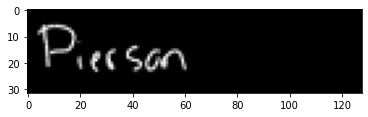



edit distance =  0
original_text =   mission
predicted text = mission

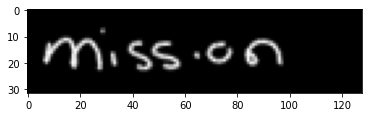



edit distance =  0
original_text =   him
predicted text = him

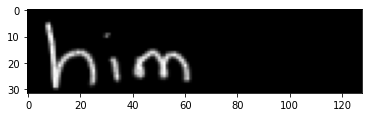



edit distance =  0
original_text =   apart
predicted text = apart

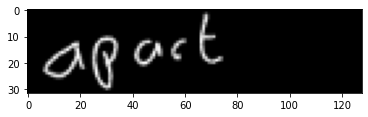



edit distance =  0
original_text =   on
predicted text = on

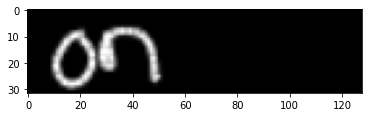

In [39]:
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

total_character = 0
edit_distance = 0
# see the results (the lower CER the better)
for i, x in enumerate(out):
    original_text = test_original_text[i]
    letters=''    
    for p in x:
        if int(p) != -1:
            letters += CHAR_LIST[int(p)]
            total_character += 1

    edit_cost = levenshtein_distance(original_text, letters)
    edit_distance += edit_cost

    if i % 70 == 0:
        print("edit distance = ", edit_cost)
        print("original_text =  ", original_text)
        print("predicted text = ", end = '')
        for p in x:
            if int(p) != -1:
                print(CHAR_LIST[int(p)], end = '')
        plt.imshow(test_images[i].reshape(32,128), cmap=plt.cm.gray)
        plt.show()
        print('\n')

In [37]:
print("CER: ", edit_distance/total_character)
print("Total edits: ", edit_distance)
print("Total Character: ", total_character)

CER:  0.1800595238095238
Total edits:  242
Total Character:  1344
